In [1]:
import os
import urllib
import librosa
import numpy as np
from funcs import *
import pandas as pd
import regex
from string import punctuation
from python_speech_features import mfcc, logfbank

## EDA

In [2]:
song_df = pd.read_csv('./data/song_genres.csv')

In [3]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80743 entries, 0 to 80742
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                80743 non-null  object
 1   genre             80743 non-null  object
 2   track_name        80743 non-null  object
 3   preview_url       43614 non-null  object
 4   location          80743 non-null  object
 5   filename          80743 non-null  object
 6   artist            80743 non-null  object
 7   artist_uri        80743 non-null  object
 8   album             80743 non-null  object
 9   release_date      80743 non-null  object
 10  danceability      80743 non-null  object
 11  energy            80743 non-null  object
 12  key               80743 non-null  object
 13  loudness          80743 non-null  object
 14  mode              80743 non-null  object
 15  speechiness       80743 non-null  object
 16  acousticness      80743 non-null  object
 17  instrumental

In [4]:
#We only want songs that have preview urls
song_df = song_df.copy()[song_df['preview_url'].notnull()]

In [5]:
# There are some residual headers left over from when we stored our csvs. Let's remove them.
song_df = song_df.copy()[song_df['track_name'] != 'track_name']

In [6]:
# The same song may have been in multiple playlists, so let's get rid of those
song_df.drop_duplicates(inplace=True)

In [7]:
song_df['track_name'].unique().shape[0]

4986

We've collected **4986 unique songs**, I want to have at least 500 in each genre I'm looking at. Let's see which genres have at least 500 songs in our dataset

In [8]:
genre_over_500 = song_df['genre'].value_counts() >= 500

In [9]:
song_df['genre'].value_counts()[genre_over_500]

classical                1406
rap                      1051
pop rap                   893
classical performance     725
r&b                       723
trap                      692
pop                       679
urban contemporary        673
dance pop                 653
hip hop                   572
early music               569
progressive bluegrass     559
rock                      540
Name: genre, dtype: int64

With this info, I'm going to look at the following genres to start:
* rap
* classical
* rock
* progressive bluegrass
* r&b


In [10]:
song_df_5_genres = song_df[song_df['genre'].isin(['rap', 'classical', 'rock', 'progressive bluegrass', 'r&b'])]

In [11]:
song_df_5_genres.drop_duplicates(subset=['id'])['genre'].value_counts()

classical                1206
r&b                       560
rap                       553
rock                      535
progressive bluegrass     500
Name: genre, dtype: int64

In [12]:
size = 500        # sample size
pick_samples = lambda x: x.sample(size) # without replacement by default

# Thanks Zero from stack overflow for this: https://stackoverflow.com/questions/22472213/python-random-selection-per-group
songs_sampled_500 = song_df_5_genres.groupby('genre', as_index=False).apply(pick_samples).reset_index(drop=True)

In [15]:
# Let's save this to a .csv
songs_sampled_500.to_csv('./data/five_genres_500_samp.csv', index=False)

In [17]:
songs_sampled_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2500 non-null   object
 1   genre             2500 non-null   object
 2   track_name        2500 non-null   object
 3   preview_url       2500 non-null   object
 4   location          2500 non-null   object
 5   filename          2500 non-null   object
 6   artist            2500 non-null   object
 7   artist_uri        2500 non-null   object
 8   album             2500 non-null   object
 9   release_date      2500 non-null   object
 10  danceability      2500 non-null   object
 11  energy            2500 non-null   object
 12  key               2500 non-null   object
 13  loudness          2500 non-null   object
 14  mode              2500 non-null   object
 15  speechiness       2500 non-null   object
 16  acousticness      2500 non-null   object
 17  instrumentalne

In [18]:
songs_sampled_500['genre'].value_counts()

classical                500
rock                     500
rap                      500
progressive bluegrass    500
r&b                      500
Name: genre, dtype: int64

In [19]:
genres = list(songs_sampled_500['genre'].unique())

In [21]:
# Now let's get the 30-second song sample into something we can use
for i in range(songs_sampled_500.shape[0]):
    # We need to get the preview url, genre, and track name for file naming
    url = songs_sampled_500.loc[i, "preview_url"]
    genre = songs_sampled_500.loc[i, "genre"]
    track_name = songs_sampled_500.loc[i, "track_name"]
    
    # People put a lot of symbols in their songs (esp. classical music), so we need to clean those
    track_name = ' '.join(regex.findall('[A-Za-z0-9]+', track_name))
    
    # Let's open the mp3 file and make folders
    mp3file = urllib.request.urlopen(url)
    os.makedirs(f'./scrapes/{genre}', exist_ok=True)

    # Let's write this song to a folder! Adding z-filled numbers to counter songs with the same title being overwritten
    with open(f'./scrapes/{genre}/{str(i).zfill(4)}_{track_name.strip(punctuation)}.mp3','wb') as output:
          output.write(mp3file.read())

In [22]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for g in genres:
    g_df = songs_sampled_500[songs_sampled_500['genre'] == g].head(2) # Create a dataframe for the class
    for i in range(2):
        track_name = g_df.loc[g_df.index[i], "track_name"]
        track_name = ' '.join(regex.findall('[A-Za-z0-9]+', track_name))
        signal, rate = librosa.load(f'./scrapes/{g}/{str(g_df.index[i]).zfill(4)}_{track_name.strip(punctuation)}.mp3') # Get the signal and rate from each file
        mask = envelope(signal, rate, 0.0005)
        signal = signal[mask] # Cutting out the silences at the beginning and end (if any)
        signals[f'{g}_{i + 1}'] = signal
        fft[f'{g}_{i + 1}'] = calc_fft(signal, rate)
        bank = logfbank(signal[:rate], 
                        rate, 
                        nfilt=26, 
                        nfft=1103).T
        fbank[f'{g}_{i + 1}'] = bank
        mfccs[f'{g}_{i + 1}'] = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=round(int(44100) / 40)).T
        print(f'Finished with folder {g}_{i + 1}, moving on!')

Finished with folder classical_1, moving on!


C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Finished with folder classical_2, moving on!
Finished with folder progressive bluegrass_1, moving on!
Finished with folder progressive bluegrass_2, moving on!
Finished with folder r&b_1, moving on!
Finished with folder r&b_2, moving on!
Finished with folder rap_1, moving on!
Finished with folder rap_2, moving on!
Finished with folder rock_1, moving on!
Finished with folder rock_2, moving on!


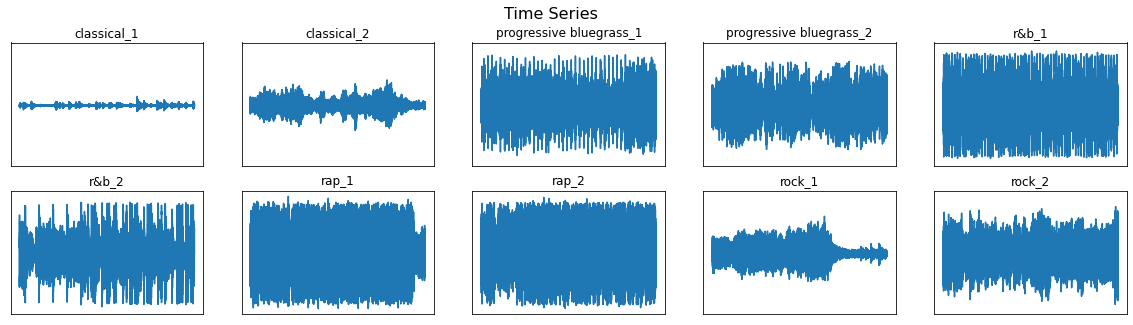

In [23]:
plot_signals(signals);

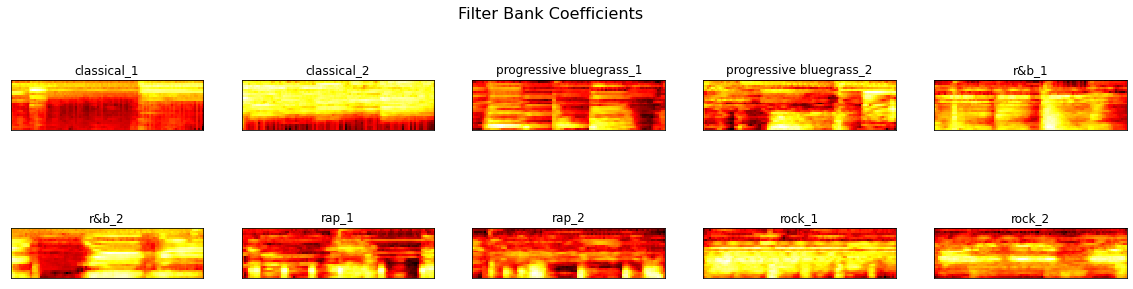

In [24]:
plot_fbank(fbank, signals);

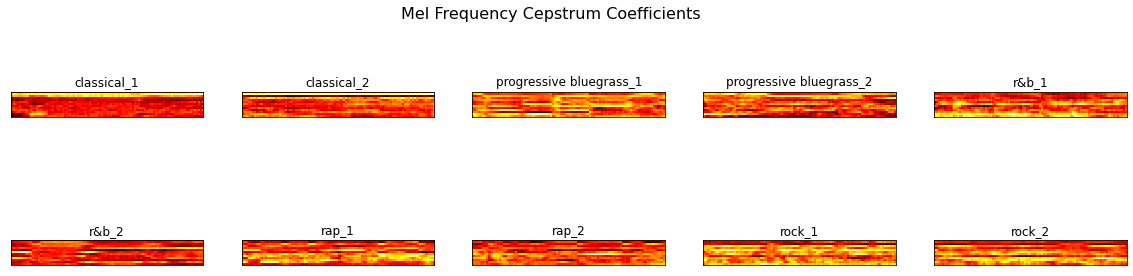

In [25]:
plot_mfccs(mfccs, signals);

### Insights

Right now, this is very basic EDA that I am borrowing from [Seth Adams's video](https://www.youtube.com/watch?v=Z7YM-HAz-IY&list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P), and many of these graphs are the same song. What I'll need to do next is scrape many different genre-based playlists until I can identify 5-10 genres that seem to be the most popular.

Even with this limited EDA, the Mel Frequency Cepstrum Coefficients for songs do look different, and if there are common traits between songs within genres, I will be able to classify them.